In [1]:
from __future__ import division, print_function

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt

In [2]:
Normal = tf.distributions.Normal
Bernoulli = tf.distributions.Bernoulli

### Utility functions

In [3]:
def permute(X, y=None):
    n_all_cases = X.shape[0]
    perm = np.arange(n_all_cases)
    np.random.shuffle(perm)
    if y is not None:
        return X[perm], y[perm]
    else:
        return X[perm], None

In [90]:
def plot_latent_space(model, onehot_encoder, X, y):
    m, sd = model.encode2(X)
    m_flat = m.reshape(-1)
    sd_flat = sd.reshape(-1)
    y_decoded = onehot_encoder.inverse_transform(y).reshape(-1)
    plt.figure(figsize=(10, 10))
    plt.scatter(m_flat, sd_flat, c=y_decoded, cmap='brg')
    plt.colorbar()
    plt.show()

### Import MNIST

In [5]:
mnist = tf.keras.datasets.mnist

### Load data

In [6]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [7]:
y_train.shape

(60000,)

In [8]:
X = np.concatenate((X_train, X_test), axis=0)

In [9]:
n_all_cases = X.shape[0]
input_dim = X.shape[1]

In [10]:
X = np.reshape(X, (n_all_cases, -1))
y = np.concatenate((y_train, y_test)).astype('float32')

In [11]:
label_reshaped = y.reshape(len(y), 1)
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
onehot_encoded = onehot_encoder.fit_transform(label_reshaped)

In [12]:
n_classes = onehot_encoded.shape[1]

In [13]:
X = (X > 0.5).astype(np.float32)

In [14]:
X_perm, onehot_encoded_perm = permute(X,onehot_encoded)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_perm, onehot_encoded_perm, test_size=0.1, random_state=40)

In [16]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
y_test.shape

(7000, 10)

### Utility functions

In [18]:
def get_log_folder():
    now = datetime.datetime.now()
    day_of_the_year=now.strftime("%d_%m_%Y")
    suff = now.strftime("%Y%m%d%H%M%S")
    #print(now.strftime("%Y%m%d%H%M%S"))
    log_folder = "/tmp/class_vae/deep/{}/{}".format(day_of_the_year,suff)
    return log_folder

### Build neural network

In [69]:
class DenseLayer:

    def __init__(self, in_dim, out_dim, layer, f=tf.nn.relu, name="dense"):
        self.name = name
        with tf.name_scope(self.name):
            self.f = f
#             self.W = tf.Variable(tf.truncated_normal(shape=(in_dim, out_dim), stddev=0.1), name="W")
            self.W = tf.get_variable(name="W_{}".format(layer), shape=(in_dim, out_dim), initializer=tf.contrib.layers.xavier_initializer())

            self.b = tf.Variable(tf.constant(0.1, shape=[out_dim]), name="bias")
            tf.summary.histogram("weights", self.W)
            tf.summary.histogram("bias", self.b)

    def forward(self, X):
        with tf.name_scope(self.name):
            act = self.f(tf.matmul(X, self.W) + self.b)
            tf.summary.histogram("activation", act)
            return act

In [91]:
class VClassifier:

    def encode(self, X, middle_layer_dim):
        current_value = X
        for layer in self.encoder_layers:
            current_value = layer.forward(current_value)

        means = current_value[:, :middle_layer_dim]
        stdevs = tf.nn.softplus(current_value[:, middle_layer_dim:]) + 1e-6
        return means, stdevs
    
    def create_encoder(self, X, input_dim, hidden_dims):
        
        in_dim = input_dim
        for h_dim in hidden_dims[:-1]:
            self.layer = self.layer + 1
            h = DenseLayer(in_dim, h_dim, layer=self.layer)
            self.encoder_layers.append(h)
            in_dim = h_dim

        middle_layer_dim = hidden_dims[-1]
        self.layer = self.layer + 1
        self.encoder_layers.append(DenseLayer(in_dim, 2 * middle_layer_dim, layer=self.layer, f=lambda x: x))

        return self.encode(X, middle_layer_dim)
    
    def decode(self, Z, output_dim, hidden_dims):
        decoder_layers = []

        in_dim = hidden_dims[-1]
        for hidden_dim in reversed(hidden_dims[:-1]):
            self.layer = self.layer + 1
            h = DenseLayer(in_dim, hidden_dim, layer=self.layer)
            decoder_layers.append(h)
            in_dim = hidden_dim

        self.layer = self.layer + 1
        decoder_layers.append(DenseLayer(in_dim, output_dim, layer=self.layer, f=lambda x: x))

        current_value = Z
        for decoder_layer in decoder_layers:
            current_value = decoder_layer.forward(current_value)

        return current_value
    
    def calculateKL(self, mean, std):
        inner = 1 + tf.math.log(1e-8 + std ** 2) - mean ** 2 - std ** 2
        kls = 0.5 * tf.math.reduce_sum(inner, axis=1)
        return tf.math.reduce_mean(kls)
    
    def create_accuracy_node(self, y_true, y_pred):
        correct_mask_node = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
        accuracy_node = tf.reduce_mean(tf.cast(correct_mask_node, tf.float32))
        return accuracy_node

    def __init__(self, x_dim, y_dim, hidden_dims, log_folder):
        self.encoder_layers = []
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.layer = 1
        
        tf.reset_default_graph()
        self.X = tf.placeholder(tf.float32, shape=(None, x_dim), name="x")
        self.y = tf.placeholder(tf.float32, shape=(None, y_dim), name="y")

        #encoder
        self.means, self.stdevs = self.create_encoder(self.X, x_dim, hidden_dims)

        n = Normal(
          loc=self.means,
          scale=self.stdevs,
        )
        Z = n.sample()
        
#         n_z = hidden_dims[-1]
#         eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
#                                dtype=tf.float32)
#         # z = mu + sigma*epsilon
#         Z = tf.add(self.means, 
#                         tf.sqrt(self.stdevs * eps))
        
        print("Hidden shape: {}".format(Z.shape))

        #decoder
        self.logits = self.decode(Z, (x_dim+y_dim), hidden_dims)

        self.XY_hat_distribution = Bernoulli(logits=self.logits)
        #self.posterior_predictive = self.Y_hat_distribution.sample()

        #with tf.name_scope('sample_output_reshaped'):
        #    posterior_predictive_reshaped = tf.reshape(self.posterior_predictive, [-1, 28, 28, 1])
        #    tf.summary.image('sample_output', tf.cast(posterior_predictive_reshaped, tf.float32), 10)

        self.posterior_predictive_probs = tf.nn.sigmoid(self.logits)
        
        if y_dim > 0:
            self.posterior_predictive_probs_y = self.posterior_predictive_probs[:,x_dim:(x_dim+y_dim)]
            print("self.posterior_predictive_probs_y.shape {}".format(self.posterior_predictive_probs_y.get_shape().as_list()))
            print("self.y.shape {}".format(self.y.get_shape().as_list()))
            self.accuracy_node = self.create_accuracy_node(self.y, self.posterior_predictive_probs_y)
            tf.summary.scalar("accuracy", self.accuracy_node)

        # with tf.name_scope('probs_output_reshaped'):
        #     posterior_predictive_probs_reshaped = tf.reshape(self.posterior_predictive_probs[:,0:x_dim], [-1, 28, 28, 1])
        #     tf.summary.image('probs_output', posterior_predictive_probs_reshaped, 10)

        with tf.name_scope('COST'):
            
            if y_dim > 0:
                xy = tf.concat([self.X, self.y], axis=1)
            else:
                xy = self.X
            print("xy.shape {}".format(xy.get_shape().as_list()))
            expected_log_likelihood = tf.reduce_sum(
                self.XY_hat_distribution.log_prob(xy),
                axis=1
            )
            #tf.summary.scalar("Expected log-likelihood", tf.reduce_sum(expected_log_likelihood))

            kl = self.calculateKL(self.means, self.stdevs)
            tf.summary.scalar("KL", kl)

            exp_loglik = tf.reduce_mean(expected_log_likelihood)
            tf.summary.scalar("loglik", exp_loglik)

            elbo = exp_loglik + kl
            tf.summary.scalar("ELBO", elbo)


            
        self.train_op = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(-elbo)
        #self.train_op = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(-elbo)

        self.init_op = tf.global_variables_initializer()
            
        #InteractiveSession.close()
        self.sess = tf.InteractiveSession()
        self.sess.run(self.init_op)

        self.merged_summary = tf.summary.merge_all()

        self.writer_train = tf.summary.FileWriter(log_folder)
        self.writer_train.add_graph(self.sess.graph)

    def fit(self, X_train, y_train, epochs=30, batch_sz=64):
        #costs=[]
        n_batches = len(X_train) // batch_sz
        print("n_batches:", n_batches)

        iter = 1
        for i in range(epochs):
            print("epoch: %d" % i)
            #np.random.shuffle(X_train)
            X_train, y_train = permute(X_train, y_train)
            for j in range(n_batches):
                batch_x = X_train[j * batch_sz:(j + 1) * batch_sz]
                
                if self.y_dim > 0:
                    batch_y = y_train[j * batch_sz:(j + 1) * batch_sz]
                    self.sess.run(self.train_op, feed_dict={self.X: batch_x, self.y: batch_y})
                    if j % 100 == 0:
                        s = self.sess.run(self.merged_summary, feed_dict={self.X: batch_x, self.y: batch_y})
                        self.writer_train.add_summary(s, iter)
                else:
                    self.sess.run(self.train_op, feed_dict={self.X: batch_x})
                    if j % 100 == 0:
                        s = self.sess.run(self.merged_summary, feed_dict={self.X: batch_x})
                        self.writer_train.add_summary(s, iter)
                    
                iter += 1
            
            if self.y_dim > 0:
                train_accuracy = self.calculate_accuracy(X_train, y_train)
                print("Train accuracy {}".format(train_accuracy))

        # plt.plot(costs)
        # plt.show()
        
    def calculate_accuracy(self, X, y):
        accuracy = self.sess.run(self.accuracy_node, feed_dict={self.X: X, self.y: y})
        return accuracy
        
    def predict(self, X):
        y_pred = self.sess.run(self.posterior_predictive_probs_y, feed_dict={self.X: X})
        return y_pred

#     def predict_probs(self, X):
#         return self.sess.run(self.posterior_predictive_probs, feed_dict={self.X: X})
    
    def encode2(self, X):
        means, stdevs = self.sess.run([self.means, self.stdevs], feed_dict={self.X: X})
        return means, stdevs
    

### Supervised VAE

In [92]:
log_folder = get_log_folder()
print('Starting autoencoder. Log folder={}'.format(log_folder))
X_train, X_test, y_train, y_test
model_supervised = VClassifier(x_dim=X_train.shape[1], y_dim=y_train.shape[1], hidden_dims=[512, 256, 128, 1], log_folder=log_folder)
model_supervised.fit(X_train, y_train, epochs=3)

test_acc = model_supervised.calculate_accuracy(X=X_test, y=y_test)
print("Test accuracy {}".format(test_acc))


Starting autoencoder. Log folder=/tmp/class_vae/deep/10_03_2019/20190310183954
Hidden shape: (?, 1)
self.posterior_predictive_probs_y.shape [None, 10]
self.y.shape [None, 10]
xy.shape [None, 794]


/anaconda3/envs/cost-prediction-env/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 984
epoch: 0
Train accuracy 0.4167936444282532
epoch: 1
Train accuracy 0.4844761788845062
epoch: 2
Train accuracy 0.5434603095054626
Test accuracy 0.5398571491241455


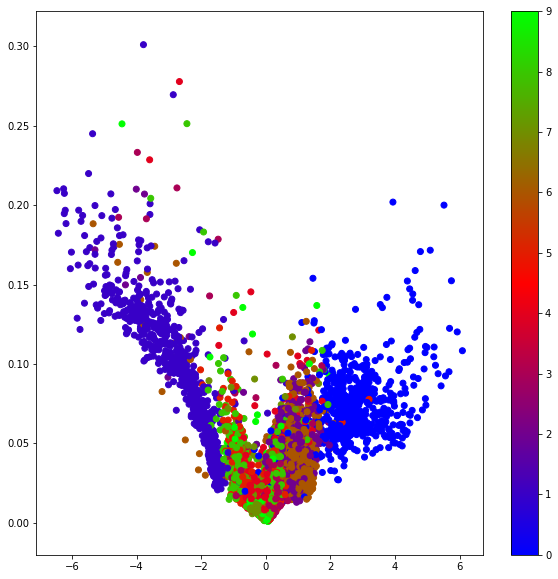

In [93]:
plot_latent_space(model_supervised, onehot_encoder, X_test, y_test)

### Unsupervised VAE

In [23]:
log_folder = get_log_folder()
print('Starting autoencoder. Log folder={}'.format(log_folder))
model_unsupervised = VClassifier(x_dim=X_train.shape[1], y_dim=0, hidden_dims=[512, 256, 128, 1], log_folder=log_folder)
model_unsupervised.fit(X_train, None, epochs=1)

# test_acc = model.calculate_accuracy(X=X_test, y=y_test)
# print("Test accuracy {}".format(test_acc))


Starting autoencoder. Log folder=/tmp/class_vae/deep/09_03_2019/20190309180056
Hidden shape: (?, 1)
xy.shape [None, 784]


/anaconda3/envs/cost-prediction-env/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 984
epoch: 0


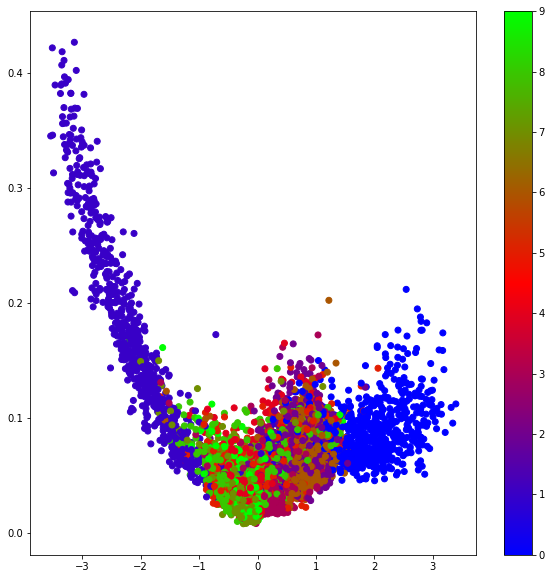

In [24]:
plot_latent_space(model_unsupervised, onehot_encoder, X_test, y_test)